In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import numpy as np
sns.set(style="whitegrid")

### Comparison of word choice metrics

In [5]:
root = '/data0/lucy/ingroup_lang/'

In [33]:
count_cut_off = 0
pmi_cut_off = 0.2
tfidf_cut_off = 2
sensepmi_cut_off = 0.3

In [7]:
def metric_correlation(metric1, metric2, sr_f, path1, path2): 
    df1 = pd.read_csv(path1 + sr_f, engine='python')
    df2 = pd.read_csv(path2 + sr_f, engine='python')
    df = pd.merge(df1, df2, on='word', how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    plt.title(sr_f)
    plt.show()
def metric_correlation_generic(metric1, metric2, path1, path2, join_on, title, ylog=False, ylim=None): 
    df1 = pd.read_csv(path1, engine='python')
    df2 = pd.read_csv(path2, engine='python')
    df = pd.merge(df1, df2, on=join_on, how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    if ylog: 
        plt.yscale('log')
    if ylim: 
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

(0.9086093715326576, 0.0)


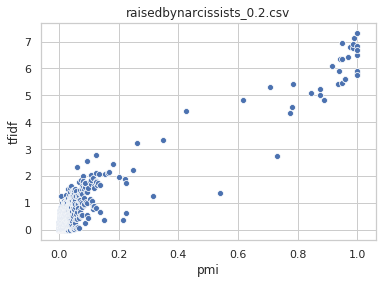

In [8]:
metric_correlation('pmi', 'tfidf', 'raisedbynarcissists_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

(0.6307617210824069, 0.0)


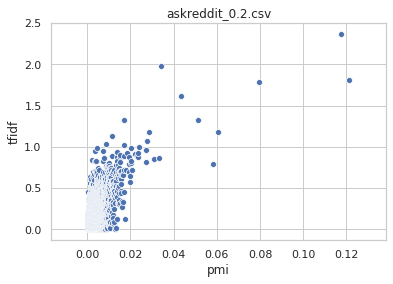

In [9]:
metric_correlation('pmi', 'tfidf', 'askreddit_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

### Comparison of user metrics

(0.21344521958285168, 2.7467224122880737e-06)


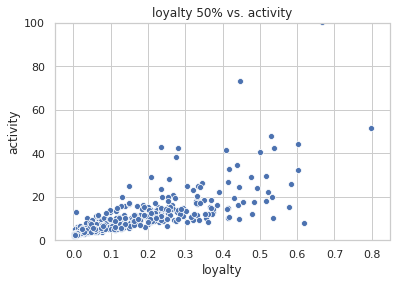

In [10]:
# for different thresholds, the pearson corr is still around 0.22
# however there are subreddits with similar levels of activity but different loyalty
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_activity'
metric_correlation_generic('loyalty', 'activity', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. activity', ylim=(0,100))

(0.47110993439816284, 1.4687530397471959e-27)


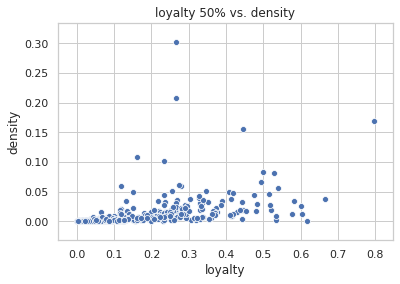

In [11]:
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_density'
metric_correlation_generic('loyalty', 'density', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. density')

### Word choice vs. word frequency

In [12]:
def metric_vs_frequency(metric_name, path, n): 
    # generate plot for 10 subreddits
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.scatterplot(x='count', y=metric_name, data=df)
        p.figure.get_axes()[0].set_xscale('log')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

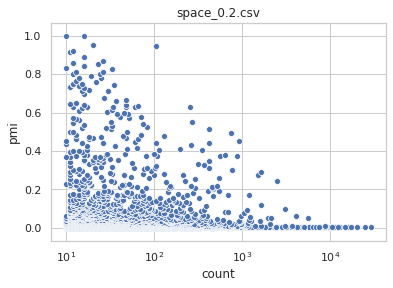

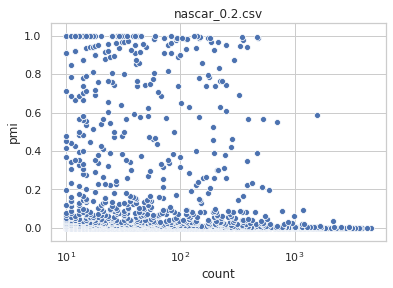

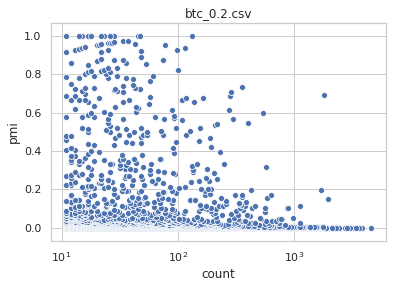

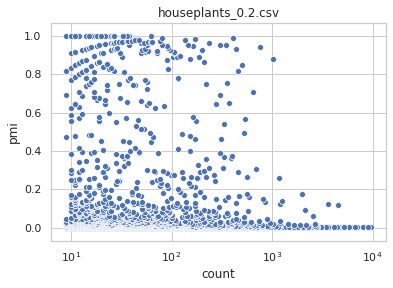

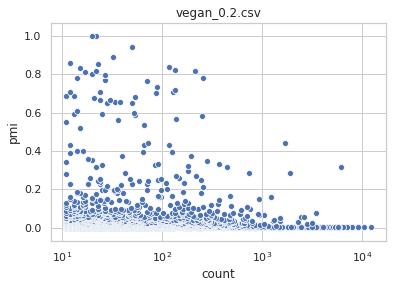

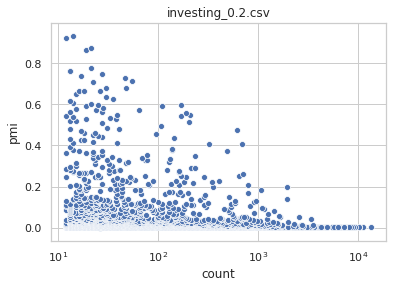

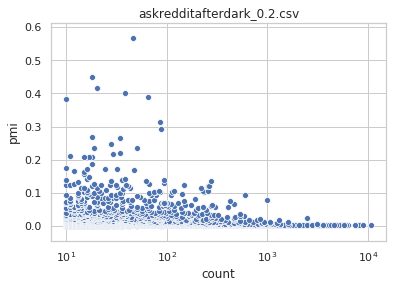

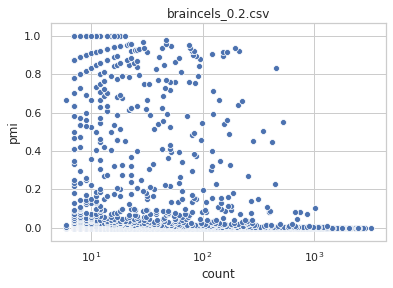

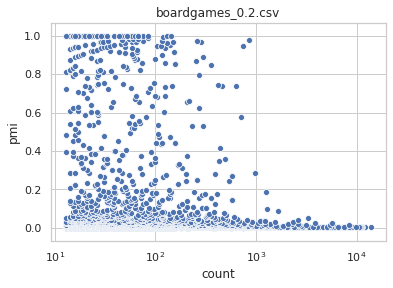

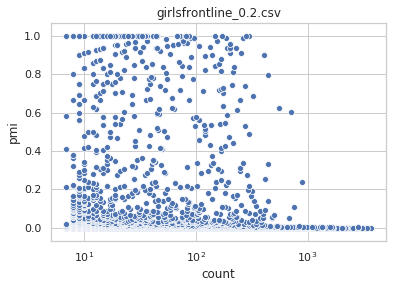

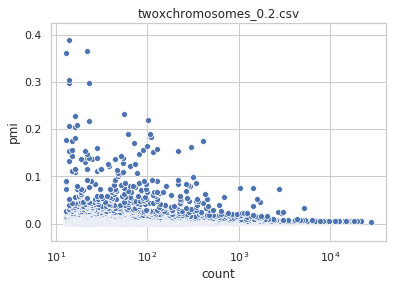

In [13]:
metric_vs_frequency('pmi', root + 'logs/pmi/', 10)

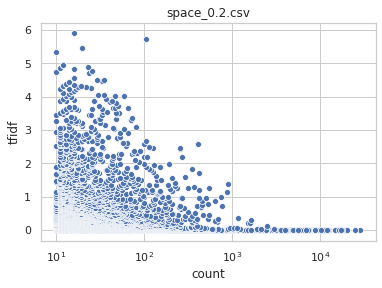

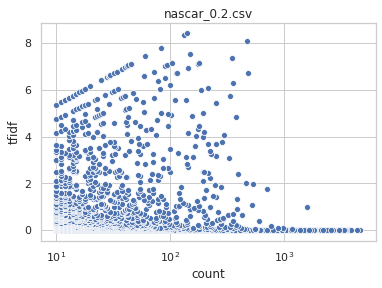

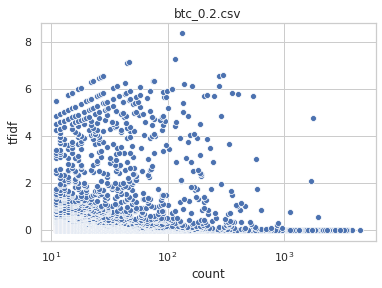

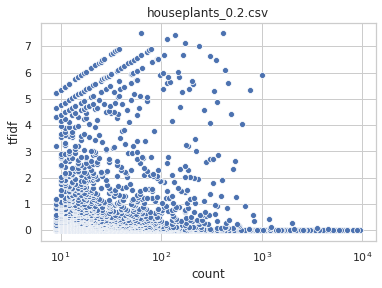

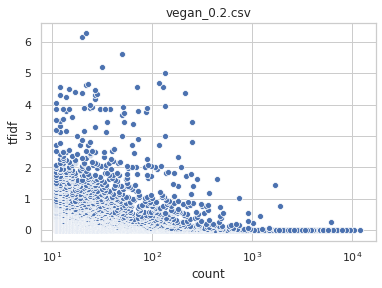

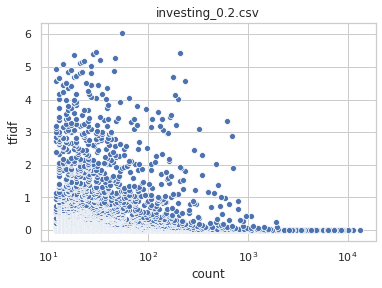

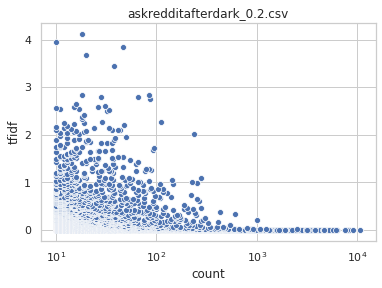

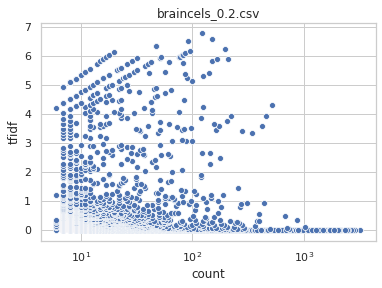

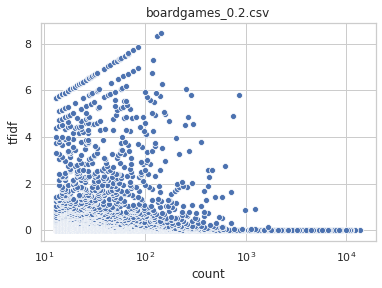

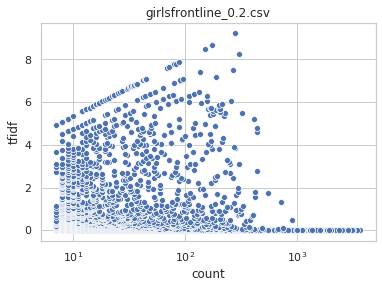

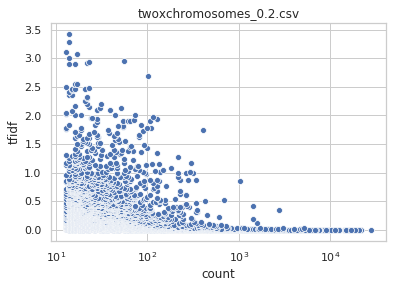

In [14]:
metric_vs_frequency('tfidf', root + 'logs/tfidf/', 10)

In [15]:
def single_metric_vs_frequency(sr_f, metric_name, path): 
    df = pd.read_csv(path + sr_f, engine='python')
    df = df[df['count'] > count_cut_off]
    p = sns.scatterplot(x='count', y=metric_name, data=df)
    p.figure.get_axes()[0].set_xscale('log')
    plt.title(sr_f)
    plt.show()

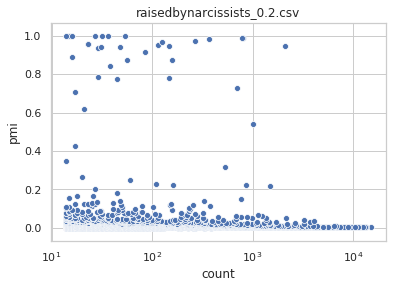

In [16]:
# Look at a single subreddit
single_metric_vs_frequency('raisedbynarcissists_0.2.csv', 'pmi', root + 'logs/pmi/')

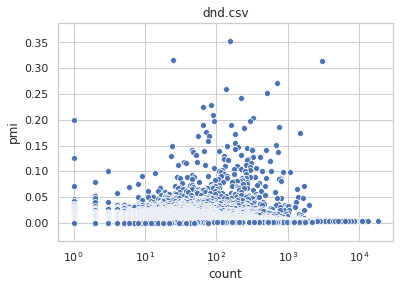

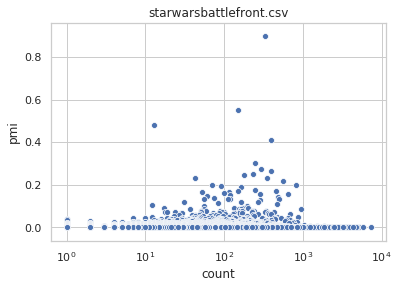

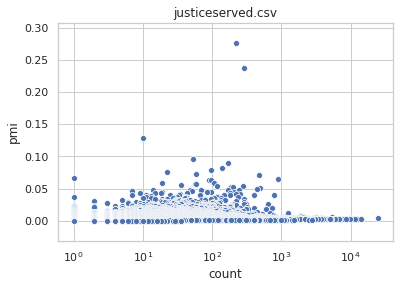

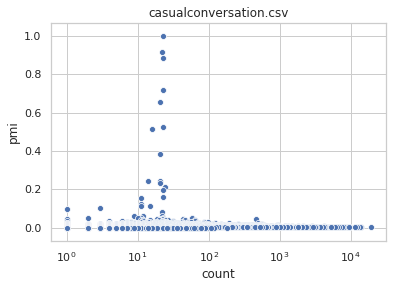

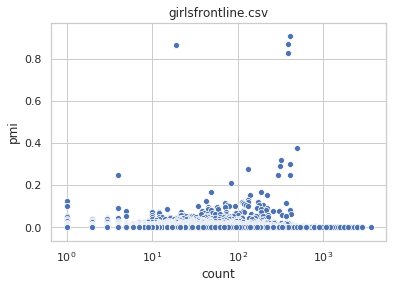

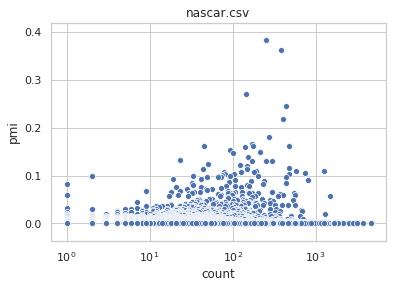

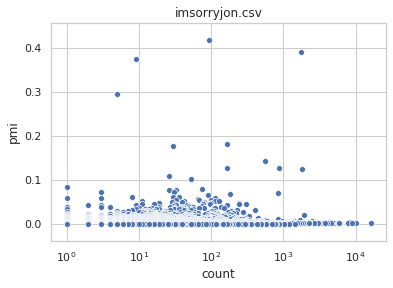

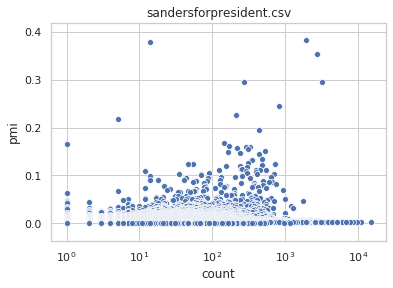

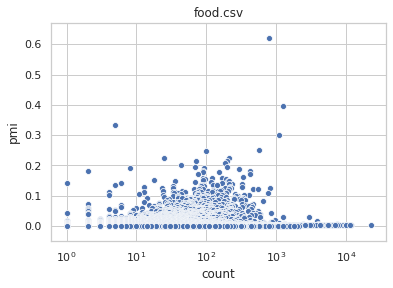

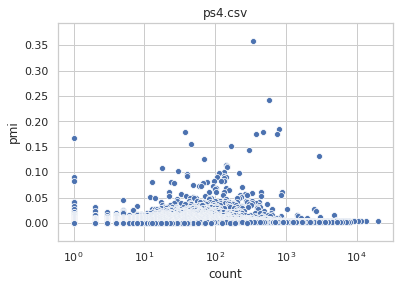

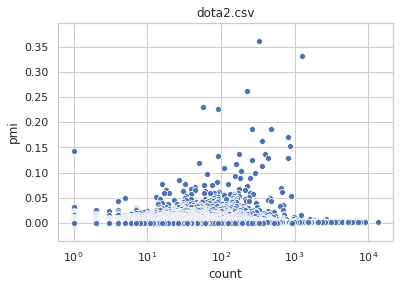

In [30]:
# sense pmi vs sense frequency
metric_vs_frequency('pmi', root + 'logs/finetuned_sense_pmi/', 10)

### Histogram of word choice values

In [17]:
def word_choice_hist(metric_name, path, n): 
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.distplot(a=df[metric_name], kde=False)
        plt.yscale('log')
        plt.ylabel('# of words')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

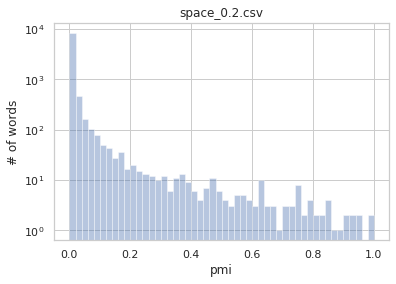

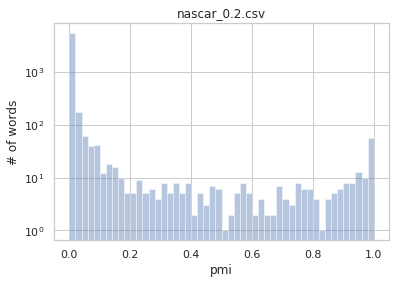

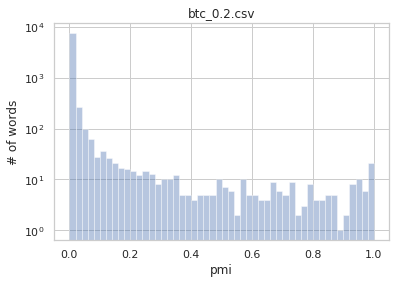

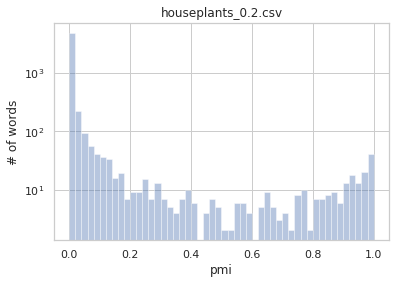

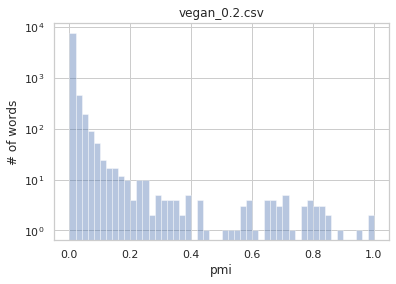

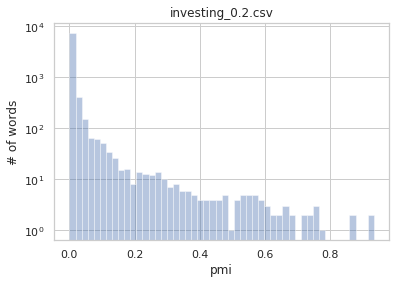

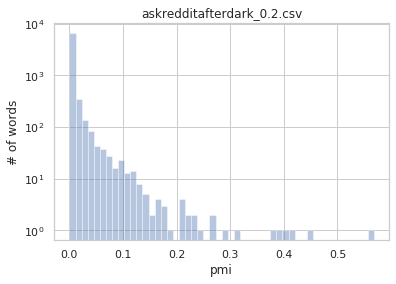

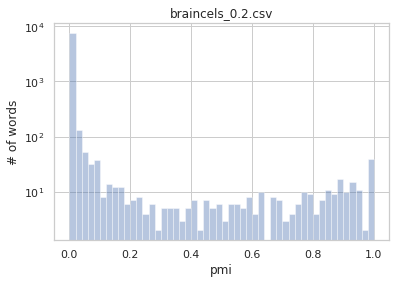

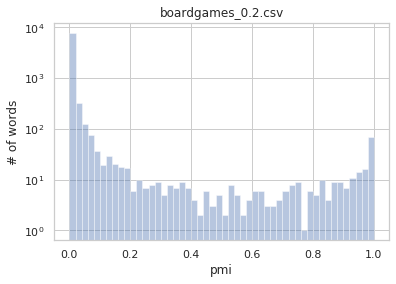

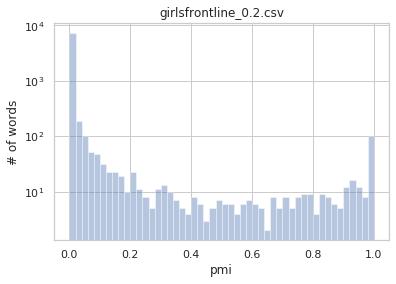

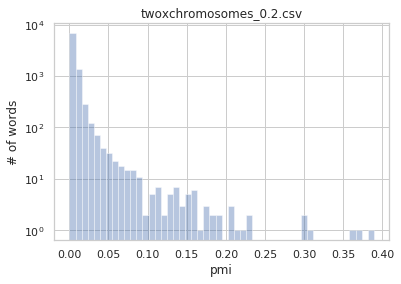

In [18]:
word_choice_hist('pmi', root+'/logs/pmi/', 10)

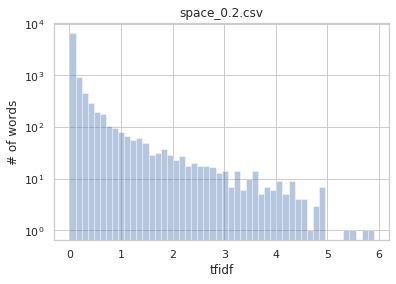

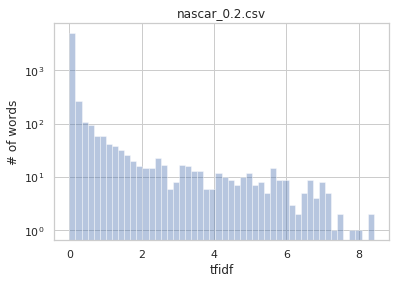

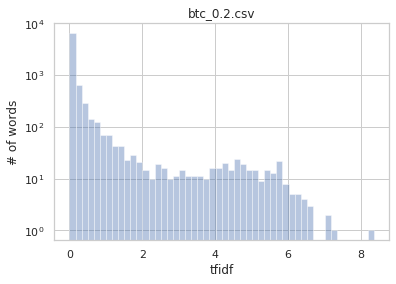

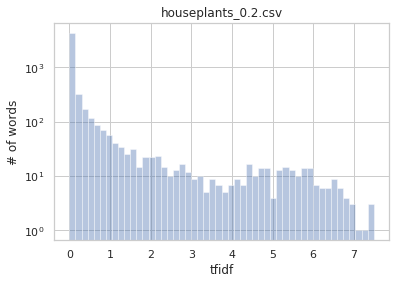

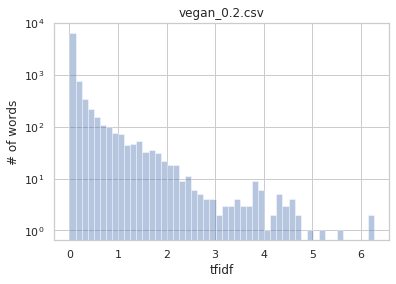

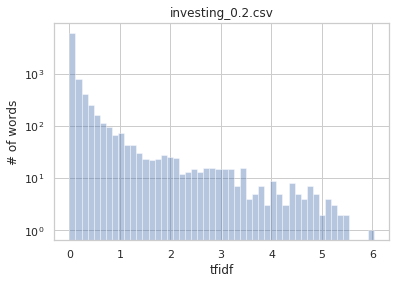

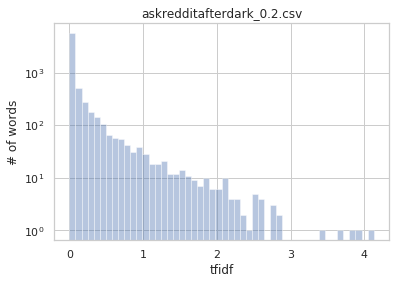

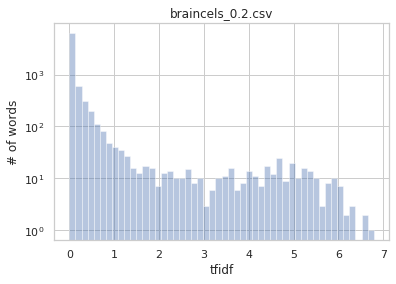

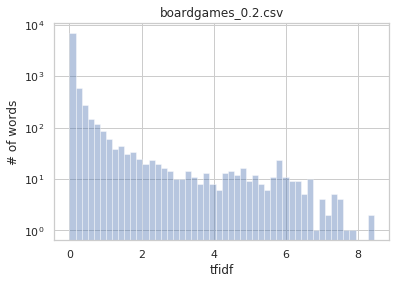

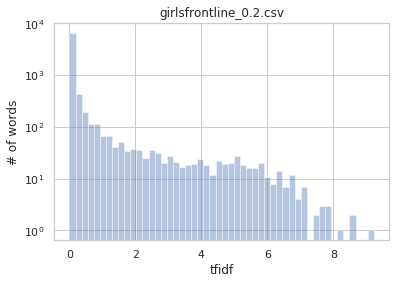

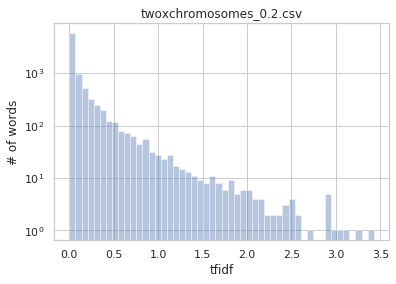

In [19]:
word_choice_hist('tfidf', root+'/logs/tfidf/', 10)

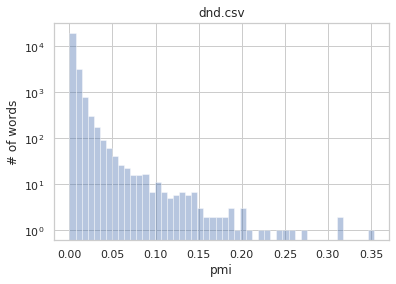

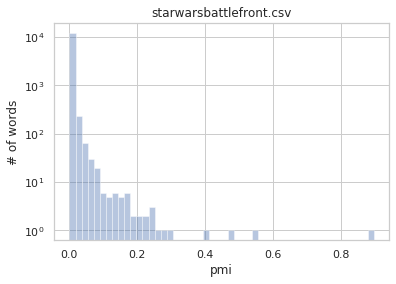

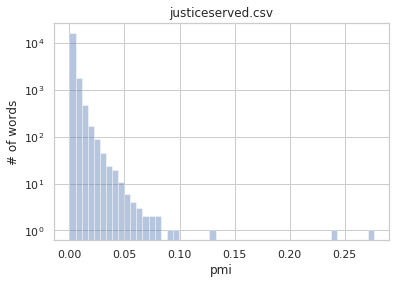

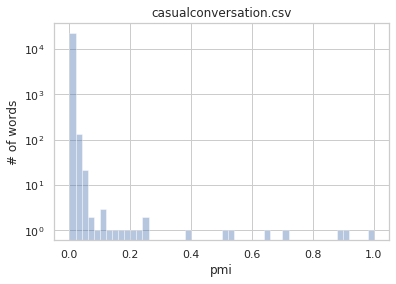

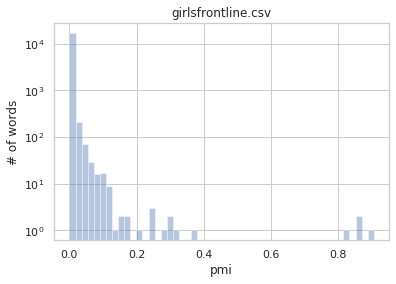

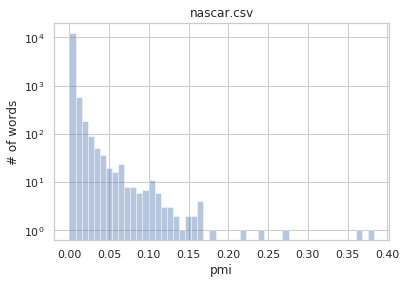

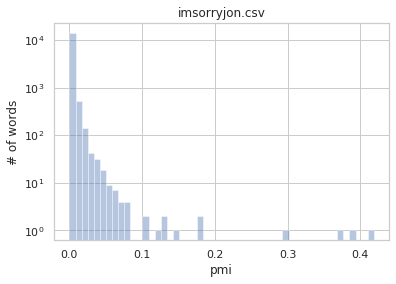

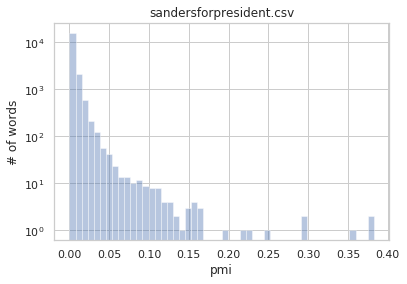

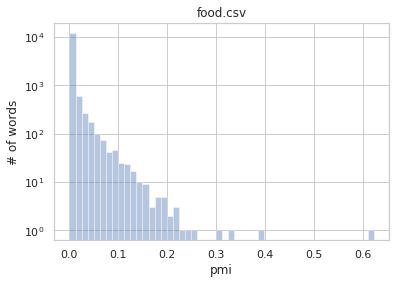

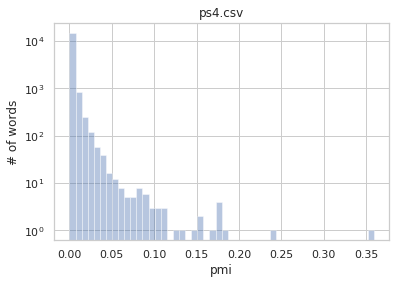

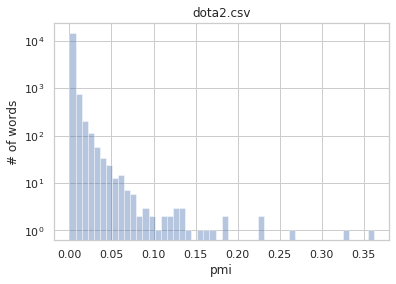

In [31]:
word_choice_hist('pmi', root+'/logs/finetuned_sense_pmi/', 10)

### Size of community vs word choice

In [43]:
def community_size_word_choice(commentor_path, metric_name, path, cut_off, xlabel, scatter=False, 
                               xlog=True, xlim=None): 
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    suffix = '_0.2.csv'
    y = []
    x = []
    srs = []
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        y.append(score)
        x.append(sr_ncoms[subreddit][0])
        srs.append(subreddit)
    if scatter == True: 
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.5, marker='.')
        if xlog: 
            plt.xscale('log')
    else: 
        if xlog: 
            x = np.log10(x)
        g = sns.jointplot(x, y, kind='hex')
    if xlim: 
        plt.xlim(xlim)
    plt.ylabel(metric_name + ' > ' + str(cut_off) + ' / total words')
    plt.xlabel(xlabel)
    plt.show()

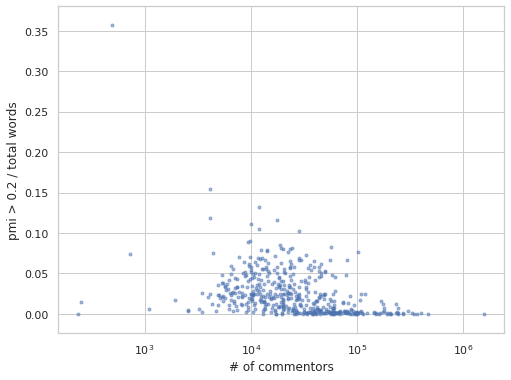

In [21]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', pmi_cut_off, 
                           '# of commentors', scatter=True)

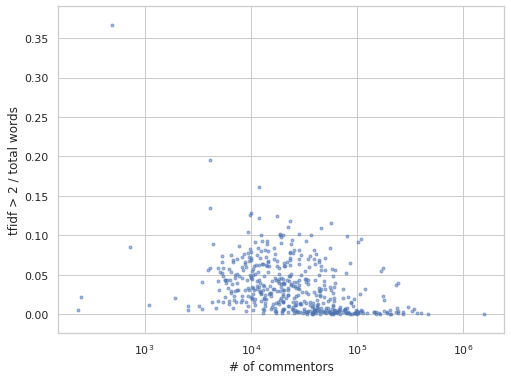

In [22]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', tfidf_cut_off, 
                           '# of commentors', scatter=True)

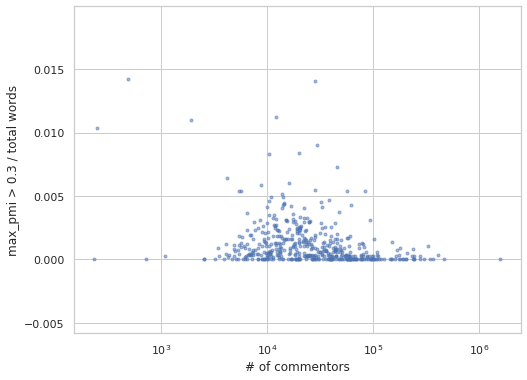

In [44]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_size_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', sensepmi_cut_off, 
                           '# of commentors', scatter=True)

### User activity vs word choice

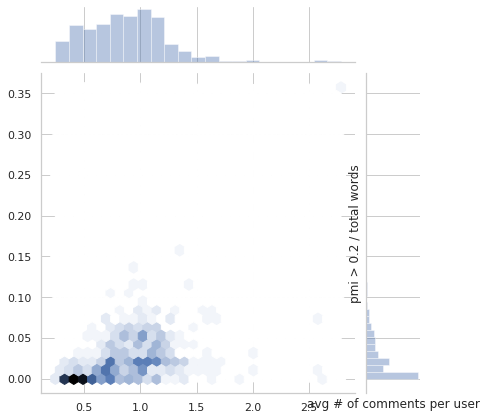

In [23]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user')

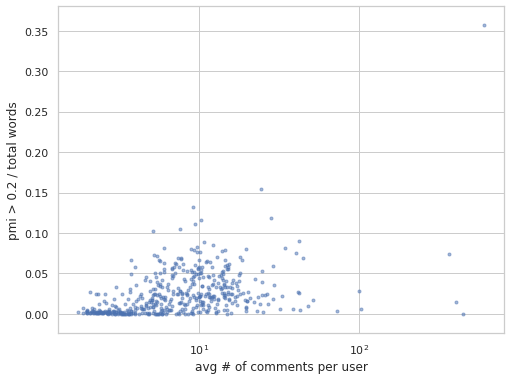

In [24]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user', scatter=True)

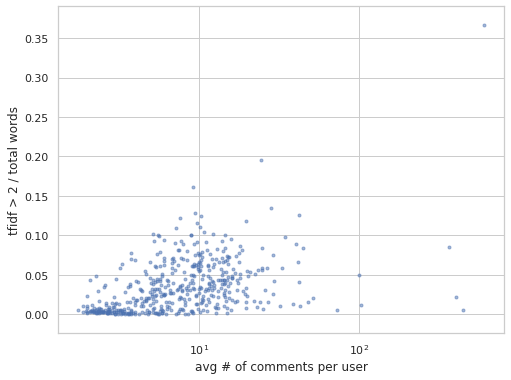

In [25]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'avg # of comments per user', scatter=True)

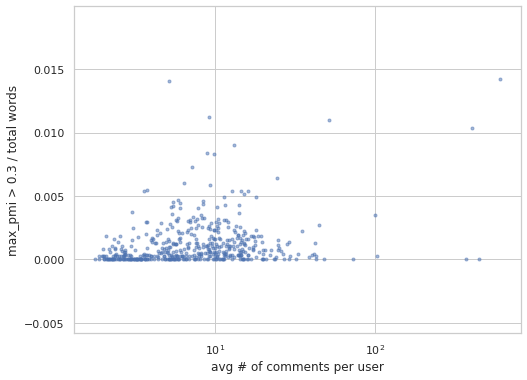

In [45]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off,  'avg # of comments per user', scatter=True)

### User loyalty vs word choice

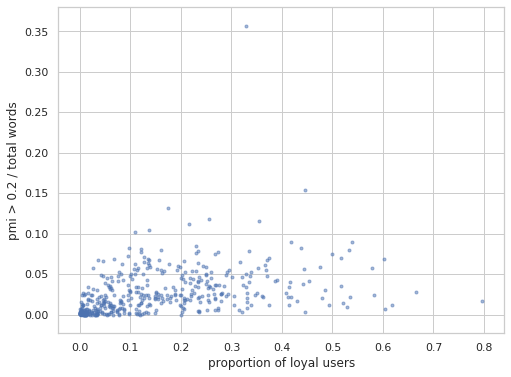

In [26]:
threshold = 50
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

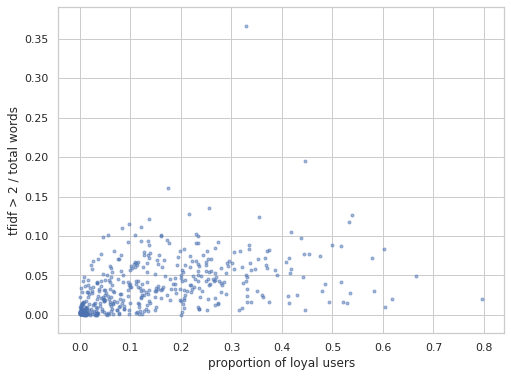

In [27]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'proportion of loyal users', scatter=True, xlog=False)

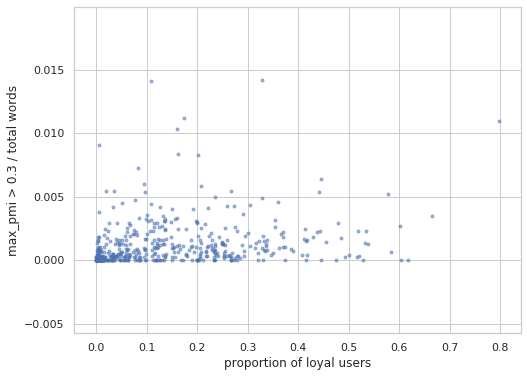

In [47]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_size_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

### User density vs. word choice

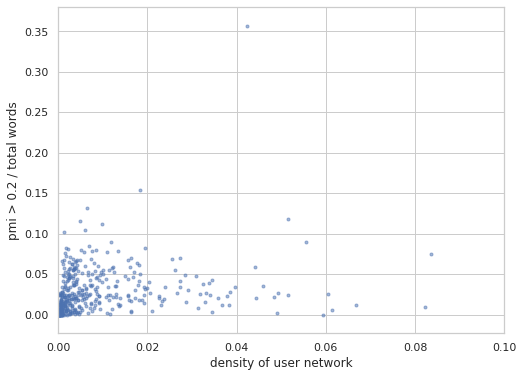

In [28]:
commentor_path = root + 'logs/commentor_density'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

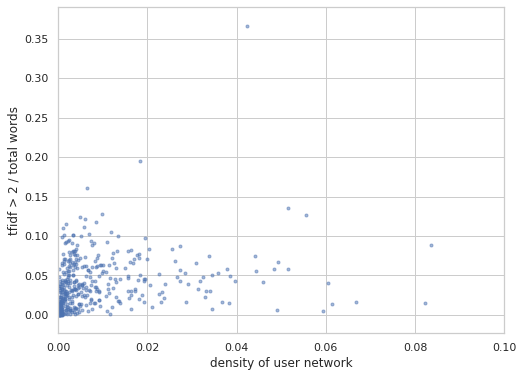

In [29]:
commentor_path = root + 'logs/commentor_density'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

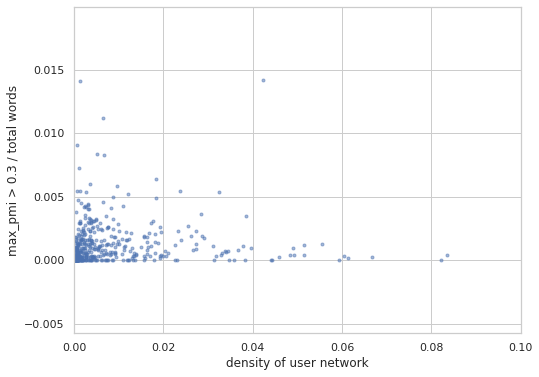

In [48]:
commentor_path = root + 'logs/commentor_density'
community_size_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

## Topics

In [63]:
from collections import defaultdict, Counter

In [75]:
topics = {}
with open('../data/subreddit_topics.txt', 'r') as infile:
    prefix = ''
    curr_title = ''
    for line in infile: 
        if line.startswith('*'): 
            prefix = line.replace('*', '').strip()
            curr_title = prefix
        if line.startswith('~'):
            curr_title = prefix + '_' + line.replace('~', '').strip()
        if line.startswith('/r/'): 
            subreddit = line.replace('/r/', '').strip().split()[0].lower()
            topics[subreddit] = curr_title

In [76]:
reddits = set()
non_english_reddits = set()
with open('../data/non_english_sr.txt', 'r') as inputfile: 
    for line in inputfile: 
        non_english_reddits.add(line.strip().lower())
with open('../data/subreddit_list.txt', 'r') as inputfile: 
    for line in inputfile: 
        sr = line.strip().lower()
        if sr not in non_english_reddits: 
            reddits.add(sr)
topic_counts = Counter()
for sr in reddits: 
    if sr in topics: 
        umbrella = topics[sr].split('_')[0]
        smaller_topic = topics[sr]
        topic = umbrella
        if umbrella in set(['Entertainment', 'Other', 'Lifestyle']): 
            topic = smaller_topic
        topic_counts[topic] += 1
topic_assignments = {}
for sr in reddits:
    if sr in topics: 
        if topic_counts[topics[sr]] >= 10: 
            topic_assignments[sr] = topics[sr]
        else: 
            topic_assignments[sr] = 'Other'
    else: 
        topic_assignments[sr] = 'Other'

In [78]:
def get_topic_df(metric_name, path, cut_off):
    d = {'scores' : [], 'subreddit': [], 'topic': []}
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace('_0.2.csv', '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        d['scores'].append(score)
        d['subreddit'].append(subreddit)
        d['topic'].append(topic_assignments[subreddit])
    return pd.DataFrame(data=d)

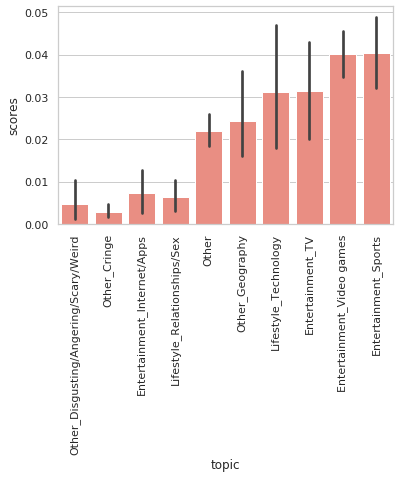

In [97]:
df = get_topic_df('pmi', root + '/logs/pmi/', 0.2)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

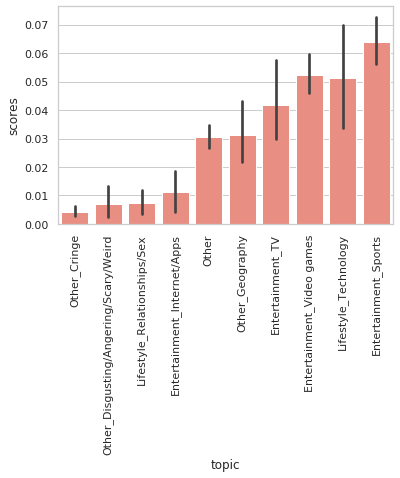

In [98]:
df = get_topic_df('tfidf', root + '/logs/tfidf/', 2)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

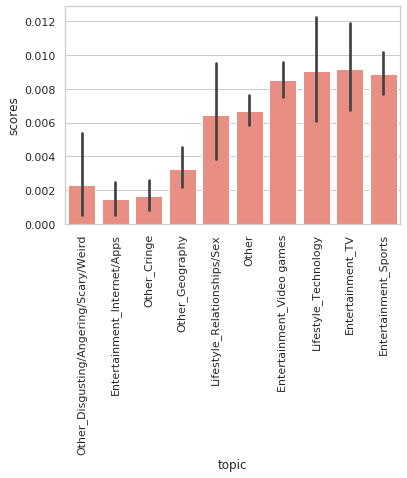

In [99]:
df = get_topic_df('max_pmi', root + '/logs/ft_max_sense_pmi/', 0.1)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()